In [ ]:
THEMES = [5, 6, 26, 33, 139, 163, 232, 313, 339, 350, 406, 409, 555, 589,
          597, 634, 660, 695, 729, 766, 773, 793, 800, 810, 852, 895, 951, 975]

## Data Fetching

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from ast import literal_eval
import pandas as pd

def groupby_process(df):
    new_df = df.sort_values(['process_id', 'page'])
    new_df = new_df.groupby(
                ['process_id', 'themes'],
                group_keys=False
            ).apply(lambda x: x.body.str.cat(sep=' ')).reset_index()
    new_df = new_df.rename(index=str, columns={0: "body"})
    return new_df

def get_data(path, preds=None, key=None):
    data = pd.read_csv(path)
    data = data.rename(columns={ 'pages': 'page'})
    data = groupby_process(data)
    data.themes = data.themes.apply(lambda x: literal_eval(x))
    return data

corpus_data = get_data('./CSV/train_small.csv')
corpus_data.themes = corpus_data.themes.apply(lambda x: list(set(sorted([i if i in THEMES else 0 for i in x]))))


## Preprocessing

### Tokenizing

In [ ]:
import nltk
from tqdm import tqdm
from joblib import Parallel, delayed

with tqdm(total=corpus_data.shape[0]*2) as pbar:
    # tokenizing words by whitespace
    corpus_data['body'] = [nltk.word_tokenize(word_data, language='portuguese') for word_data in corpus_data['body']]

    pbar.update(corpus_data.shape[0])

    # removing words with length < 3
    def remove_small_words(tokens):
        pbar.update(1)
        return [word for word in tokens if len(word) > 3]

    corpus_data['body'] = [remove_small_words(tokens) for tokens in corpus_data['body']]

    # _ = Parallel(n_jobs=-1)(delayed(remove_small_words)(tokens) for tokens in corpus_data['body'])

corpus_data

### Stopword removal

In [ ]:
# get portuguese stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')

# stopword removal
with tqdm(total=corpus_data.shape[0]) as pbar:
    def remove_stopwords(tokens):
        pbar.update(1)
        return [token for token in tokens if token not in stopwords]

    corpus_data['body'] = [remove_stopwords(tokens) for tokens in corpus_data['body']]

## Rejoin words

In [ ]:
# smush all tokens together
corpus_data['body'] = [' '.join(tokens) for tokens in corpus_data['body']]

## Save results

In [ ]:
import pickle 

fh = open('./pickled/mineracao.pkl', 'wb')
pickle.dump(corpus_data, fh)
fh.close()

## Resume results

In [1]:
import pickle 

fh = open('./pickled/mineracao.pkl', 'rb')
corpus_data = pickle.load(fh)
fh.close()

## Vectorizing X and Y training data

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

def transform_y(labels):
    mlb = MultiLabelBinarizer()
    mlb.fit(labels)

    mlb_data = mlb.transform(labels)

    print(mlb.classes_)

    return mlb_data, mlb

y_data, mlb = transform_y(corpus_data.themes)

tfidf_model = TfidfVectorizer(ngram_range=(1, 1), sublinear_tf=True, min_df=0.1, max_features=10000)
X_data = tfidf_model.fit_transform(corpus_data.body, corpus_data.themes)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33)

[  0   5   6  26  33 139 163 232 313 339 350 406 409 555 589 597 634 660
 695 729 766 773 793 800 810 852 895 951 975]


## Kfold validation

In [3]:
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import pandas as pd

onevsrest_scores = []

kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train)

for train_index, test_index in kf.split(X_train):
     # separando treino e teste
     X_ktrain, X_ktest = X_train[train_index], X_train[test_index]
     y_ktrain, y_ktest = y_train[train_index], y_train[test_index]

     # treinando modelo
     kfold_model = OneVsRestClassifier(MultinomialNB(alpha=0.001, fit_prior=True), n_jobs=-1).fit(X_ktrain, y_ktrain)

     # avaliando a acurácia
     train_score = kfold_model.score(X_ktrain, y_ktrain)
     test_score = kfold_model.score(X_ktest, y_ktest)
     onevsrest_scores.append([train_score, test_score])
     # print("Train Score: ", train_score, "\tTest Score: ", test_score)

onevsrest_scores_df = pd.DataFrame(onevsrest_scores, columns=["0train", "0test"])
onevsrest_scores_df

,0train,0test
0,0.298851,0.288043
1,0.293406,0.277174
2,0.296431,0.239130
3,0.294616,0.304348
4,0.297036,0.288043
5,0.297036,0.282609
6,0.294011,0.282609
7,0.295042,0.262295
8,0.304716,0.229508
9,0.293833,0.256831


In [4]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

linearsvc_scores = []

kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train)

for train_index, test_index in kf.split(X_train):
     # separando treino e teste
     X_ktrain, X_ktest = X_train[train_index], X_train[test_index]
     y_ktrain, y_ktest = y_train[train_index], y_train[test_index]

     # treinando modelo
     kfold_model = OneVsRestClassifier(LinearSVC(class_weight="balanced"), n_jobs=-1).fit(X_ktrain, y_ktrain)

     # avaliando a acurácia
     train_score = kfold_model.score(X_ktrain, y_ktrain)
     test_score = kfold_model.score(X_ktest, y_ktest)
     linearsvc_scores.append([train_score, test_score])
     # print("Train Score: ", train_score, "\tTest Score: ", test_score)

linearsvc_scores_df = pd.DataFrame(linearsvc_scores, columns=["1train", "1test"])
linearsvc_scores_df

,1train,1test
0,0.834241,0.690217
1,0.826376,0.673913
2,0.835451,0.673913
3,0.837871,0.711957
4,0.834241,0.695652
5,0.838475,0.673913
6,0.843315,0.625000
7,0.834946,0.726776
8,0.829504,0.677596
9,0.840387,0.617486


## Train Models

In [5]:
onevsrest_model = OneVsRestClassifier(MultinomialNB(alpha=0.001, fit_prior=True), n_jobs=-1).fit(X_train, y_train)

train_score = onevsrest_model.score(X_train, y_train)
test_score = onevsrest_model.score(X_test, y_test)
print("Train Score: ", train_score, "\tTest Score: ", test_score)

Train Score:  0.2934131736526946 	Test Score:  0.24503311258278146


In [6]:
linearsvc_model = OneVsRestClassifier(LinearSVC(class_weight="balanced"), n_jobs=-1).fit(X_train, y_train)

train_score = linearsvc_model.score(X_train, y_train)
test_score = linearsvc_model.score(X_test, y_test)
print("Train Score: ", train_score, "\tTest Score: ", test_score)

Train Score:  0.833968426782798 	Test Score:  0.6633554083885209


## Data Visualizing

[]

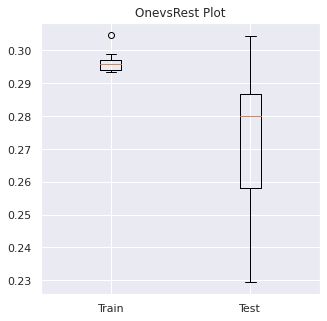

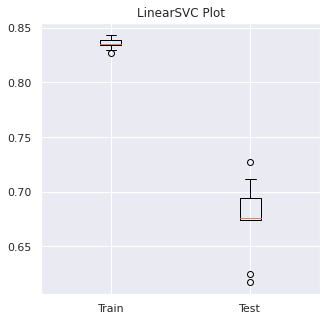

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig1, axs = plt.subplots(figsize=(5, 5))
axs.set_title('OnevsRest Plot')
axs.boxplot(onevsrest_scores_df, labels=("Train", "Test"))
plt.savefig("./output/onevsrestaccuracy.png")
plt.plot()

fig1, axs = plt.subplots(figsize=(5, 5))
axs.set_title('LinearSVC Plot')
axs.boxplot(linearsvc_scores_df, labels=("Train", "Test"))
plt.savefig("./output/linearsvcaccuracy.png")
plt.plot()


One vs Rest model


<Figure size 1080x1080 with 0 Axes>

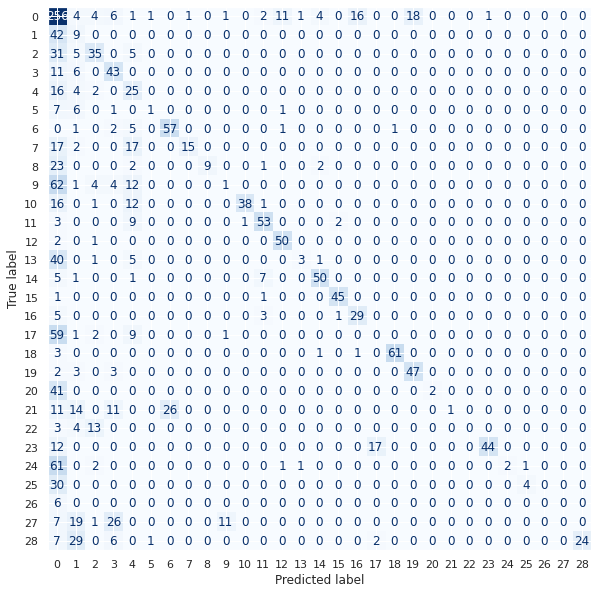

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = onevsrest_model.predict(X_train)
fig = plt.figure(figsize=(15, 15))

cm = confusion_matrix(y_train.argmax(axis=1), predictions.argmax(axis=1), labels=onevsrest_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=onevsrest_model.classes_)
print("One vs Rest model")
disp.plot(cmap=plt.cm.Blues, include_values=True, colorbar=False)
plt.savefig("./output/onevsrestconfusion.png")

Linear SVC model


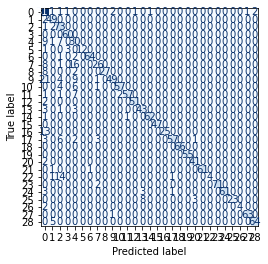

In [9]:
predictions = linearsvc_model.predict(X_train)
fig = plt.figure(figsize=(15, 15))

cm = confusion_matrix(y_train.argmax(axis=1), predictions.argmax(axis=1), labels=linearsvc_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linearsvc_model.classes_)
print("Linear SVC model")
disp.plot(cmap=plt.cm.Blues, include_values=True, colorbar=False)
plt.savefig("./output/linearsvcconfusion.png")

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1837 samples in 0.002s...
[t-SNE] Computed neighbors for 1837 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1837
[t-SNE] Computed conditional probabilities for sample 1837 / 1837
[t-SNE] Mean sigma: 0.312624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.164040
[t-SNE] KL divergence after 1000 iterations: 0.509556


/usr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


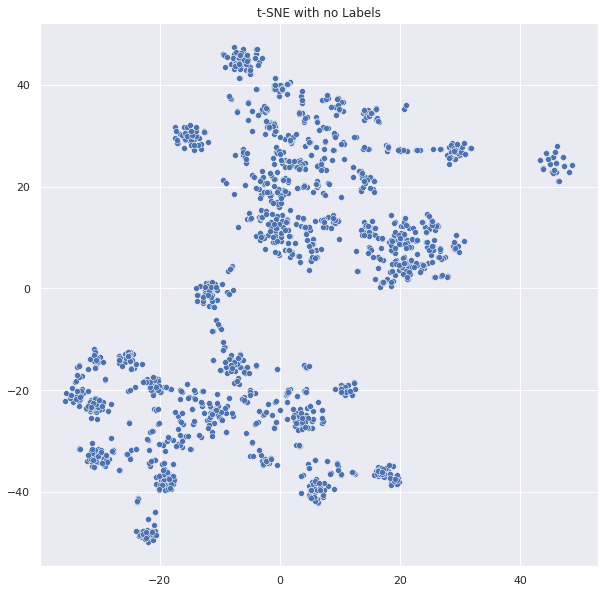

In [10]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

tsne = TSNE(verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(X_train.toarray())

# sns settings
sns.set(rc={'figure.figsize':(10,10)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("./output/clustering-ste.png")
plt.show()

## Word importance by theme

In [11]:
from wordcloud import WordCloud
from joblib import Parallel, delayed

def word_importance_by_theme(classifier, tag, tags_classes, index_to_words):
	coefs = classifier.coef_[tags_classes.index(tag)]
	sortedWords = {}

	for coef, x in sorted(zip(coefs, range(len(coefs)))):
		sortedWords[index_to_words[x]] = coef

	return sortedWords

def generate_wc_freqs(s_theme, classifier):
	word_coefs = word_importance_by_theme(classifier, s_theme, mlb.classes_.tolist(), {i:word for word,i in tfidf_model.vocabulary_.items()})

	create_wordcloud_freqs(word_coefs, str(s_theme) + '_importance_wc.png')
	# pbar.update(1)

def create_wordcloud_freqs(word_coefs, file_path):
	# create wordcloud object
	wc = WordCloud(background_color="white", width=1280, height=720, max_words=200, collocations = False).generate_from_frequencies(word_coefs)

	# save wordcloud
	wc.to_file('./output/' + file_path)

themes = mlb.classes_

# _ = Parallel(n_jobs=-1)(delayed(generate_wc_freqs)(s_theme, linearsvc_model) for s_theme in themes)
# [generate_wc_freqs(s_theme, linearsvc_model) for s_theme in themes]